# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('./Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('./Udacity_CUSTOMERS_052018.csv', sep=';')


/anaconda2/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Be sure to add in a lot more cells (both markdown and code) to document your
# approach and findings!
#azdias['CAMEO_INTL_2015']

### Data Cleaning
#### 1. Data Cleaning - convert unknown values to `NaN`
The first step is to look at the features and the range of possible of each range. The description of each column can be found in `DIAS Information Levels - Attributes 2017.xlsx` and `DIAS Attributes - Values 2017.xlsx`. The values of each feature contains different ranges, and some represents "unknown". The first step is to manually convert these "unknowns" to NaN.


##### a) read features from attribute file

In [4]:
ATTRIBUTE_FILE="DIAS Attributes - Values 2017.xlsx"

df_Levels_Attributes = pd.read_excel(ATTRIBUTE_FILE)
#print(df_Levels_Attributes.head())
for i in range(len(df_Levels_Attributes["Attribute"])):
    if pd.isna(df_Levels_Attributes.iloc[i]["Attribute"]):
        df_Levels_Attributes.at[i,"Attribute"] = attr_name
    else:
        attr_name = df_Levels_Attributes.iloc[i]["Attribute"]

COLUMN_UNKNOWN_VALUE = dict()
for index, row in df_Levels_Attributes[df_Levels_Attributes["Meaning"] == "unknown"].iterrows():
    COLUMN_UNKNOWN_VALUE[row["Attribute"]] = [int(n) for n in str(row["Value"]).split(",")]
#print(sorted([key for key in azdias.columns]))

INTEGER_LABELS_COLUMN = {"ANZ_HAUSHALTE_AKTIV", "ANZ_HH_TITEL", "ANZ_PERSONEN", 
                         "ANZ_TITEL", "GEBURTSJAHR", "KBA13_ANZAHL_PKW", "MIN_GEBAEUDEJAHR"}
COLUMN_LABELS = dict()
for index, row in df_Levels_Attributes[df_Levels_Attributes["Meaning"] != "unknown"].iterrows():
    if row["Attribute"] not in COLUMN_LABELS:
        COLUMN_LABELS[row["Attribute"]] = []
    if row["Attribute"] in INTEGER_LABELS_COLUMN:
        continue
    #print(row["Attribute"], row["Value"])
    COLUMN_LABELS[row["Attribute"]] += str(row["Value"]).split(",")
#COLUMN_LABELS["CAMEO_DEU_2015"]
#azdias[azdias["CAMEO_DEU_2015"] == "XX"]["CAMEO_DEU_2015"]
#azdias.loc[2511,"CAMEO_DEU_2015"] in COLUMN_LABELS["CAMEO_DEU_2015"]
#COLUMN_UNKNOWN_VALUE["CAMEO_DEU_2015"]
#set(COLUMN_LABELS.keys()) - set(azdias.columns)
#(set(azdias.columns) - set(COLUMN_LABELS.keys()))
print(set(customers.columns) - set(azdias.columns))

set(['CUSTOMER_GROUP', 'PRODUCT_GROUP', 'ONLINE_PURCHASE'])


##### b) Drop undocumented features
Many features in the azdias and customers dataframe are not explained in the attribute file. These columns are dropped.

In [5]:
UNDOCUMENTED_COLUMN = set(azdias.columns) - set(COLUMN_LABELS.keys())
print(UNDOCUMENTED_COLUMN)

azdias = azdias.drop(columns=UNDOCUMENTED_COLUMN)
customers = customers.drop(columns=UNDOCUMENTED_COLUMN)
#print(customers["ONLINE_PURCHASE"])

set(['CJT_TYP_6', 'CJT_TYP_5', 'CJT_TYP_4', 'CJT_TYP_3', 'CJT_TYP_2', 'CJT_TYP_1', 'UMFELD_JUNG', 'D19_TELKO_REST', 'D19_NAHRUNGSERGAENZUNG', 'ANZ_KINDER', 'EINGEFUEGT_AM', 'D19_SAMMELARTIKEL', 'RT_KEIN_ANREIZ', 'KONSUMZELLE', 'D19_KONSUMTYP_MAX', 'CJT_KATALOGNUTZER', 'D19_BANKEN_LOKAL', 'DSL_FLAG', 'D19_KINDERARTIKEL', 'ALTERSKATEGORIE_FEIN', 'KBA13_HHZ', 'STRUKTURTYP', 'D19_KOSMETIK', 'D19_RATGEBER', 'UNGLEICHENN_FLAG', 'RT_UEBERGROESSE', 'D19_BILDUNG', 'EXTSEL992', 'D19_DROGERIEARTIKEL', 'EINGEZOGENAM_HH_JAHR', 'D19_DIGIT_SERV', 'ARBEIT', 'D19_TELKO_ONLINE_QUOTE_12', 'VK_DHT4A', 'D19_VERSI_ONLINE_QUOTE_12', 'GEMEINDETYP', 'HH_DELTA_FLAG', 'KBA13_BAUMAX', 'D19_VOLLSORTIMENT', 'KBA13_KMH_210', 'D19_BEKLEIDUNG_REST', 'D19_VERSICHERUNGEN', 'D19_VERSI_OFFLINE_DATUM', 'D19_SCHUHE', 'D19_BEKLEIDUNG_GEH', 'D19_VERSAND_REST', 'D19_TELKO_MOBILE', 'LNR', 'D19_TIERARTIKEL', 'D19_BANKEN_REST', 'D19_VERSI_ONLINE_DATUM', 'D19_HAUS_DEKO', 'VK_ZG11', 'KOMBIALTER', 'D19_LEBENSMITTEL', 'D19_HANDWERK',

##### c) Convert values that represents "unknown" to `NaN`
In some columns, the value of `0` or `-1` actually means unknown,or some values are out-of-range. These data are replaced with `NaN`.

In [6]:
def fill_unknown_values(df):
    MISSING_COLUMN = set(COLUMN_LABELS.keys()) - set(df.columns)
    for column_name in COLUMN_LABELS:
        if column_name in MISSING_COLUMN:
            continue
        if column_name in INTEGER_LABELS_COLUMN:
            continue
        nan_mask = ~df[column_name].isin(COLUMN_LABELS[column_name])
        if column_name in COLUMN_UNKNOWN_VALUE:
            nan_mask |= df[column_name].isin(COLUMN_UNKNOWN_VALUE[column_name])
        df.loc[nan_mask, column_name] = np.nan

    # special handling
    df.loc[df["GEBURTSJAHR"] == 0, "GEBURTSJAHR"] = np.nan

print(azdias.head())    
fill_unknown_values(azdias)
print(azdias.head())

print(customers.head)    
fill_unknown_values(customers)
print(customers.head)

   AGER_TYP  ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  \
0        -1       NaN                  NaN           NaN           NaN   
1        -1       0.0                 11.0           0.0           2.0   
2        -1      17.0                 10.0           0.0           1.0   
3         2      13.0                  1.0           0.0           0.0   
4        -1      20.0                  3.0           0.0           4.0   

   ANZ_TITEL  BALLRAUM CAMEO_DEU_2015 CAMEO_DEUG_2015 CAMEO_INTL_2015  \
0        NaN       NaN            NaN             NaN             NaN   
1        0.0       6.0             8A               8              51   
2        0.0       2.0             4C               4              24   
3        0.0       4.0             2A               2              12   
4        0.0       2.0             6B               6              43   

           ...           SEMIO_VERT  SHOPPER_TYP  TITEL_KZ  VERS_TYP  \
0          ...                    1         

<bound method DataFrame.head of         AGER_TYP  ALTER_HH  ANZ_HAUSHALTE_AKTIV  ANZ_HH_TITEL  ANZ_PERSONEN  \
0            2.0      10.0                  1.0           0.0           2.0   
1            NaN      11.0                  NaN           NaN           3.0   
2            NaN       6.0                  1.0           0.0           1.0   
3            1.0       8.0                  0.0           NaN           0.0   
4            NaN      20.0                  7.0           0.0           4.0   
5            1.0      11.0                  1.0           0.0           2.0   
6            2.0      10.0                  1.0           0.0           2.0   
7            1.0      10.0                  1.0           0.0           2.0   
8            2.0       5.0                 74.0           2.0           1.0   
9            1.0      20.0                  1.0           0.0           3.0   
10           NaN      14.0                  NaN           NaN           1.0   
11           1.0    

##### d) Handle numerica strings

In [7]:
def convert_str_to_int(df, column):
    df[column] = pd.to_numeric(df[column], errors='coerce')

convert_str_to_int(azdias, "CAMEO_DEUG_2015")
convert_str_to_int(azdias, "CAMEO_INTL_2015")
convert_str_to_int(customers, "CAMEO_DEUG_2015")
convert_str_to_int(customers, "CAMEO_INTL_2015")

##### e) Check the percetage of NaN values in each column
The majority of NaN is less than 0.15% and at most 0.40% of total features in both of dataset, so it would not have significant impact on the results. 

Text(0.5,1,'Histogram')

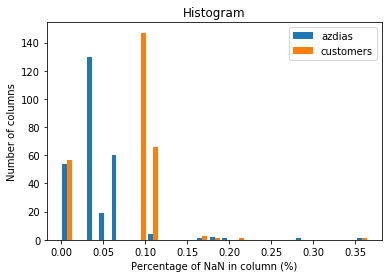

In [8]:
azdias_nan_counter = {column_name: np.sum(azdias[column_name].isna()) for column_name in azdias.columns}
customers_nan_counter = {column_name: np.sum(customers[column_name].isna()) for column_name in customers.columns}
#print([c for c in customers_nan_counter if customers_nan_counter[c] > 0])
azdias_normalized = [100.0*v/float(azdias.size) for v in azdias_nan_counter.values()]
customers_normalized = [100.0*v/float(customers.size) for v in customers_nan_counter.values()]

plt.hist([azdias_normalized, customers_normalized], bins = 25, label=["azdias", "customers"])

# Plot formatting
plt.legend()
plt.xlabel('Percentage of NaN in column (%)')
plt.ylabel('Number of columns')
plt.title('Histogram')

#### Data Cleaning - Handling catagorized values

In [9]:
def convert_biclass_to_int(df, column):
    nan_mask = df[column].notna()
    df.loc[nan_mask, column] = df[column][nan_mask].astype('category').cat.codes

convert_biclass_to_int(azdias, "OST_WEST_KZ")
convert_biclass_to_int(customers, "OST_WEST_KZ")
print(azdias.groupby("OST_WEST_KZ").groups.keys())
print(customers.groupby("OST_WEST_KZ").groups.keys())

[0, 1]
[0, 1]


In [10]:
def convert_categories_to_onehot(df, column):
    nan_mask = df[column].notna()
    df.loc[nan_mask, column] = df[column][nan_mask].astype('category')
    onehot = pd.get_dummies(df[column], prefix=column, dummy_na=True)
    print(df.columns)
    df = pd.concat([df, onehot], axis=1)
    df = df.drop(columns=[column])
    print(df.columns)
    return df
#pd.get_dummies(azdias["CAMEO_DEU_2015"], prefix="CAMEO_DEU_2015", dummy_na=True)
azdias = convert_categories_to_onehot(azdias, "CAMEO_DEU_2015")
customers = convert_categories_to_onehot(customers, "CAMEO_DEU_2015")

Index([u'AGER_TYP', u'ALTER_HH', u'ANZ_HAUSHALTE_AKTIV', u'ANZ_HH_TITEL',
       u'ANZ_PERSONEN', u'ANZ_TITEL', u'BALLRAUM', u'CAMEO_DEU_2015',
       u'CAMEO_DEUG_2015', u'CAMEO_INTL_2015',
       ...
       u'SEMIO_VERT', u'SHOPPER_TYP', u'TITEL_KZ', u'VERS_TYP',
       u'W_KEIT_KIND_HH', u'WOHNDAUER_2008', u'WOHNLAGE', u'ZABEOTYP',
       u'ANREDE_KZ', u'ALTERSKATEGORIE_GROB'],
      dtype='object', length=273)
Index([u'AGER_TYP', u'ALTER_HH', u'ANZ_HAUSHALTE_AKTIV', u'ANZ_HH_TITEL',
       u'ANZ_PERSONEN', u'ANZ_TITEL', u'BALLRAUM', u'CAMEO_DEUG_2015',
       u'CAMEO_INTL_2015', u'CJT_GESAMTTYP',
       ...
       u'CAMEO_DEU_2015_8A', u'CAMEO_DEU_2015_8B', u'CAMEO_DEU_2015_8C',
       u'CAMEO_DEU_2015_8D', u'CAMEO_DEU_2015_9A', u'CAMEO_DEU_2015_9B',
       u'CAMEO_DEU_2015_9C', u'CAMEO_DEU_2015_9D', u'CAMEO_DEU_2015_9E',
       u'CAMEO_DEU_2015_nan'],
      dtype='object', length=317)
Index([u'AGER_TYP', u'ALTER_HH', u'ANZ_HAUSHALTE_AKTIV', u'ANZ_HH_TITEL',
       u'ANZ_PERSONEN',

In [11]:
def print_groups(df):
    for column_name in df.columns:
        keys = df.groupby(column_name).groups.keys()
        if set(keys) <= set(range(25)):
            continue
        print("***** {} *****".format(column_name))
        print(keys)

#print_groups(customers)
customers.groupby("ONLINE_PURCHASE").groups.keys()

[0, 1]

#### Data Cleaning - Use mean instead of `Nan`

In [12]:
columns = list(customers.columns)
columns.remove("CUSTOMER_GROUP")
columns.remove("ONLINE_PURCHASE")
columns.remove("PRODUCT_GROUP")

for c in columns:
    customers[c].fillna(customers[c].mean(), inplace=True)
    azdias[c].fillna(azdias[c].mean(), inplace=True)
print([col for col in customers.columns if np.sum(customers[col].isna()) > 0])
print([col for col in azdias.columns if np.sum(azdias[col].isna()) > 0])


[]
[]


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1. Normalize data

In [ ]:
mean_azdias = azdias.mean()
std_azdias = azdias.std()
normalized_azdias = (azdias - mean_azdias)/std_azdias
normalized_azdias.describe()

### 2. PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA()
azdias_rotated = pca.fit_transform(normalized_azdias)
explained_variance_by_k = pca.explained_variance_ratio_.cumsum()
plt.plot(range(1,len(explained_variance_by_k)+1),explained_variance_by_k,marker="*")

### 3. K-Means Clustering

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

def show_clusters(items_rotated,labels):
    """
    plot and print clustering result
    """
    fig = plt.figure(figsize=(15, 15))
    colors =  itertools.cycle (["b","g","r","c","m","y","k"])

    grps = items_rotated.groupby(labels)
    for label,grp in grps:
        plt.scatter(grp.pc1,grp.pc2,c=next(colors),label = label)

        print "*********** Label [{}] ***********".format(label)
        names = items.loc[ grp.index,"Item_name"]
        for index, name in enumerate(names):
            print "\t<{}> {}".format(index+1,name)

    # annotate
    for itemid in items_rotated.index:
        x = items_rotated.loc[itemid,"pc1"]
        y = items_rotated.loc[itemid,"pc2"]
        name = items.loc[itemid,"Item_name"]
        name = re.sub('\W', ' ', name)
        plt.text(x,y,name)

    # plt.legend(loc="best")

In [ ]:
def cluster(n_clusters,n_components=50):
    """
    n_components=K, means use first K principle components in the clustering
    n_clusters: the number of clusters we want to cluster
    """
    print "first {} PC explain {:.1f}% variances".format(n_components,
                                                         100 * sum(pca.explained_variance_ratio_[:n_components]))

    kmeans = KMeans(n_clusters=n_clusters)
    kmeans.fit(azdias_rotated.values[:, :n_components])

    # display results
    show_clusters(azdias_rotated, kmeans.labels_)

In [ ]:
# choose best K (i.e., number of clusters)
inertias = []
silhouettes = []

ks = range(2,30)
for k in ks:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(azdias_rotated)
    
    inertias.append(kmeans.inertia_)
    silhouettes.append(silhouette_score(azdias_rotated, kmeans.predict(azdias_rotated)))

In [ ]:
fig = plt.figure(figsize=(10,4))
fig.add_subplot(1,2,1)
plt.plot(ks,inertias,marker='x')# want to use elbow method to find best k

fig.add_subplot(1,2,2)
plt.plot(ks,silhouettes,marker='o')# the higher the better

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

In [ ]:
mailout_train = pd.read_csv('Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

In [ ]:
mailout_test = pd.read_csv('Udacity_MAILOUT_052018_TEST.csv', sep=';')